In [1]:
# A simple example doing Bayesian inference for a harmonic oscillator

Uses MCMC through the KissMCMC samplers.

The forward model and other bits are defined in `bayesian-example-base.jl`

This example assumes that the times of measurements are errror-free, a simplification which the next example lifts.

LoadError: LoadError: syntax: extra token "MCMC" after end of expression
while loading In[1], in expression starting on line 3

In [2]:
# This is where the forward model, probabilistic model etc are defined.
using NBInclude
nbinclude("bayesian-ex-base.ipynb")
using Plots,StatPlots # this works only up to StatPlots 9e665438 & on 0.5 of PyCall too (14 July 2016)
@time 1 # initialze
# choose to use the analytic or ODE-forward model
fwd! = [fwd_ana!, fwd_ode!][1];

  0.000006 seconds (148 allocations: 10.151 KB)


    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.DataArray, AbstractArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:276.
To fix, define 
    +(DataArrays.DataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.
    +(AbstractArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:106
is ambiguous with: 
    +(DataArrays.AbstractDataArray, AbstractArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:300.
To fix, define 
    +(DataArrays.AbstractDataArray{T<:Any, 2}, WoodburyMatrices.SymWoodbury)
before the new definition.


## Make the synthetic `xv_measured`

In [3]:
sigma = 0.4
const ts_measured, xv_measured, A, ω, ϕ, ts_true, xv_true = make_synthetic_measurements(theta_true = [2.5, 1.1, 3], # [A, ω, ϕ]
                                                                               sigma_x=sigma,
                                                                               sigma_v=sigma,
                                                                               sigma_t=0)
@assert all(ts_measured.==ts_true)

[Plots.jl] Initializing backend: pyplot



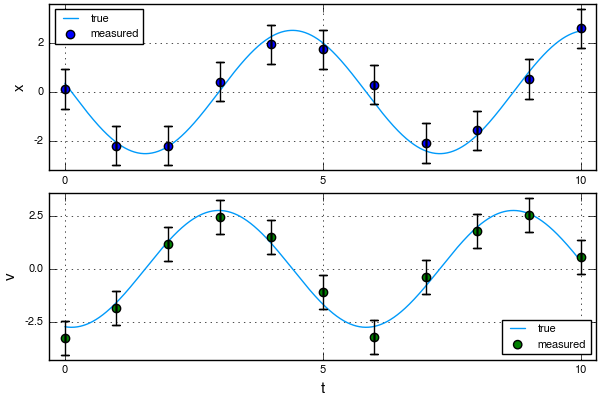

In [4]:
## Plot the measurements
using Plots, StatPlots # needs current master of StatPlots & on 0.5 of PyCall too (14 July 2016)
plotmeasurements(ts_measured,xv_measured,A,ω,ϕ,sigma_x=sigma,sigma_v=sigma)

## Probabilistic model setup

Fitting parameters `[A,ω,ϕ,sigma] = theta`

In [5]:
varnames = ["A","ω", "ϕ", "σ"]

# Likelilhood
const fwdout = init_fwd(ts_measured) # Note, this will be modified in place
function loglikelihood(theta)
    # Closure over fwdout, fwd!, xv_measured, ts_measured
    # make sure those are `const`!
    A,ω,ϕ,sigma = theta
    fwd!(fwdout, ts_measured, A,ω,ϕ)
    loglikelihood(fwdout, xv_measured, sigma)
end

# Normal & uniform priors

logprior_A(A) = 0<=A ? 0.0 : -Inf # amplitude is positive
ω_max = 15.0
logprior_ω(ω) = 0<=ω<ω_max ? 0.0 : -Inf # ω is bounded
logprior_ϕ(ϕ) = 0<=ϕ<2*pi ? 0.0 : -Inf # ϕ is bounded

sigma_est = 0.2 # our prior estimate of sigma
sigma_est_sigma = 0.2 # our estimate of the std of sigma
logprior_sigma(sigma) = sigma<=0 ? -Inf : -(sigma-sigma_est)^2/(2*sigma_est_sigma)

logprior = (theta) -> (logprior_A(theta[1]) +
                       logprior_ω(theta[2]) +
                       logprior_ϕ(theta[3]) +
                       logprior_sigma(theta[4]) )

# This is the pdf which will be estimated with MCMC
logposterior = @anon theta -> loglikelihood(theta) + logprior(theta);

## MCMC fitting

First define some parameters. Generally `_m` referes to variables connected to the Metropolis sampler, `_e` to the `emcee` sampler.

In [6]:
niter = 5*10^5 # number of MC steps
nthin = 10     # only store theta every so often
nburnin = niter÷3 # how much burn-in
nchains = 50 # number of chains used in the emcee sampler
niter_e = niter÷nchains # iterations in the emcee sampler reduced accordingly
nburnin_e = niter_e÷3; # burnin;

In [7]:
#################
# Metropolis MCMC
#################

# Using a Gaussian proposal distribution.  Note, this needs to be
# symmetric for Metropolis!

sig = 0.01  # this needs tuning, accept_ratio of 1/4 is good, they say.
const sigma_ppdf = [sig, sig, sig, sig]
sample_ppdf(theta) = [randn()*sigma_ppdf[i]+theta[i] for i=1:length(theta)]

theta_true = [A, ω, ϕ, sigma];  # good IC
theta0 = [2.1, 1.1, 1.1, 0.2]; # decent IC
# note that the emcee sampler does poorly with a poor IC!
#theta0 = [1.74,0.001, 0.25, 1.77] # bad IC

metropolis(logposterior, sample_ppdf, theta0, niter=2)
print("Metropolis: ")
@time thetas_m, accept_ratio_m = metropolis(logposterior, sample_ppdf, theta0,
                                            niter=niter, nthin=nthin, nburnin=nburnin)
print_results(thetas_m, accept_ratio_m, names=varnames, title="Metropolis", theta_true=theta_true)

Metropolis:   3.080785 seconds (16.13 M allocations: 308.748 MB, 1.61% gc time)
Metropolis
Ratio of accepted/total steps: 0.5957418085163829

var 	 err	median	 mean 	 mode 	 std
A 	 0.05 	 2.45 	 2.46 	 2.44 	 0.11
ω 	 0.01 	 1.09 	 1.09 	 1.09 	 0.01
ϕ 	 0.0 	 3.0 	 3.0 	 3.01 	 0.08
σ 	 0.04 	 0.36 	 0.37 	 0.35 	 0.07



In [8]:
#################
# emcee MCMC
#################

emcee(logposterior, (theta0, 0.1), niter=10, nchains=2)
print("emcee:")
@time thetas_ec, accept_ratio_ec = emcee(logposterior, (theta0, 0.1),
                                         niter=niter_e, nthin=nthin, nchains=nchains, nburnin=nburnin_e)
# When running this problem with IC far from the maximum, then emcee produces
thetas_e, accept_ratio_e = squash_chains(thetas_ec, accept_ratio_ec, drop_low_accept_ratio=true)
print_results(thetas_e, accept_ratio_e, names=varnames, title="emcee", theta_true=theta_true)

emcee:  2.313102 seconds (19.72 M allocations: 440.092 MB, 2.64% gc time)
Dropping low accept-ratio chain 4
Dropping low accept-ratio chain 10
Dropping low accept-ratio chain 50
emcee
Ratio of accepted/total steps: 0.5597592460802491

var 	 err	median	 mean 	 mode 	 std
A 	 0.05 	 2.45 	 2.45 	 2.45 	 0.11
ω 	 0.01 	 1.09 	 1.09 	 1.09 	 0.01
ϕ 	 0.0 	 3.0 	 3.0 	 3.0 	 0.08
σ 	 0.04 	 0.36 	 0.37 	 0.33 	 0.06



Output evaluation: plot the 1D and 2D distributions in a corner-plot.  Note that all the parameters are well estimated.  The std-deviation of the parameters depends on how much error the synthetic data contains.  $\omega$ and $\phi$ are anti-correlated, the rest are un-correlated.


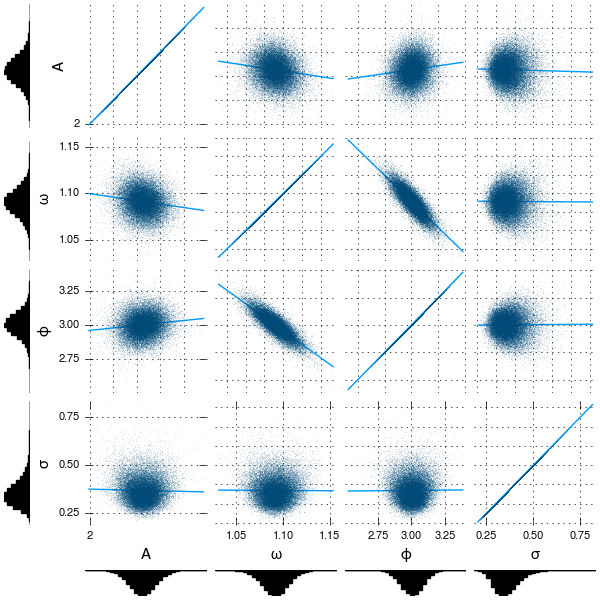

In [9]:
cornerplot(thetas_e', label=["A","ω", "ϕ", "σ"], size=(600,600))